In [1]:
import numpy as np
import pandas as pd
import arviz as az
import numpyro
import numpyro.infer.initialization as init
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, SVI, Predictive, init_to_median
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoDiagonalNormal, Trace_ELBO
from numpyro.infer.reparam import CircularReparam
import numpyro.distributions as dist
from numpyro import handlers

from asterion.gp import GP, SquaredExponential

from corner import corner

import os

In [2]:
data_dir = 'data/prior'
track_name = 'm1.0Y0.26FeH0.0MLT2.1ov0.003556dif1'
track_dir = os.path.join(data_dir, track_name)

track = pd.read_csv(os.path.join(track_dir, f'{track_name}.csv'))
track.head()

,filename,model_number,evol_stage,initial_mass,initial_Yinit,initial_Zinit,initial_feh,initial_MLT,initial_fov,star_mass,...,E_0_31,E_0_32,E_0_33,E_0_34,E_0_35,E_0_36,E_0_37,E_0_38,E_0_39,E_0_40
0,profile4,152,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.216230e-06,0.000002,0.000006,0.000279,0.000014,0.000003,0.000002,0.000001,8.677974e-07,7.314938e-07
1,profile5,153,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,1.070235e-06,0.000002,0.000004,0.000047,0.000027,0.000004,0.000002,0.000001,8.865659e-07,7.333283e-07
2,profile6,154,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.770822e-07,0.000002,0.000003,0.000022,0.000059,0.000005,0.000002,0.000001,9.058076e-07,7.371980e-07
3,profile7,155,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,9.140089e-07,0.000001,0.000003,0.000014,0.000159,0.000006,0.000002,0.000001,9.237271e-07,7.414930e-07
4,profile8,156,0,1.0,0.26,0.013153,0.0,2.1,0,1.0,...,8.694409e-07,0.000001,0.000002,0.000010,0.000672,0.000007,0.000002,0.000001,9.400169e-07,7.457830e-07


In [3]:
model_number = 708
profile = track.loc[track['model_number']==model_number].iloc[0]

In [4]:
n = np.arange(10, 30)
nu_index = [f'nu_0_{i}' for i in n]
n = n.astype(float)

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_sca = profile['delta_nu']
print('delta_nu ~', round(delta_nu_sca, 2), 'muHz')

nu_max ~ 3246.74 muHz
delta_nu ~ 146.6 muHz


Text(0, 0.5, 'nu mod. 140.74 muHz')

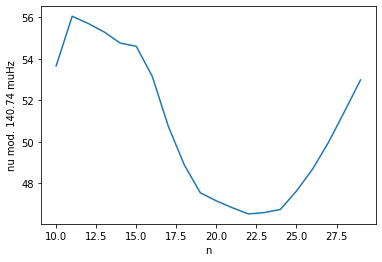

In [6]:
f = 0.96
delta_nu = f*delta_nu_sca
plt.plot(n, nu%delta_nu)
plt.xlabel('n')
plt.ylabel(f'nu mod. {delta_nu:.2f} muHz')

## Simple asymptotics

In [7]:
def linear_model(n, nu=None, nu_err=None):
    delta_nu = numpyro.sample('delta_nu', dist.Normal(141.0, 1.0))
    epsilon = numpyro.sample('epsilon', dist.Normal(1.4, 0.5))
    sigma = numpyro.sample('sigma', dist.HalfNormal(1.0))
    noise = numpyro.sample('noise', dist.HalfNormal(0.1), obs=nu_err)
    
    loc = delta_nu * (n + epsilon)
    scale = jnp.sqrt(sigma**2 + noise**2)
    
    numpyro.sample('nu', dist.Normal(loc, scale), obs=nu)

In [8]:
seed = 42
rng = random.PRNGKey(seed)

In [9]:
rng, key = random.split(rng)

prior_predictive = Predictive(linear_model, num_samples=1000)
prior_pred = prior_predictive(key, n)

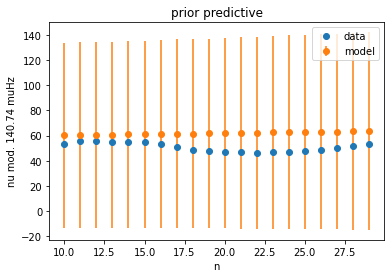

In [10]:
mean = prior_pred['nu'].mean(axis=0)
sd = prior_pred['nu'].std(axis=0)

fig, ax = plt.subplots()
ax.plot(n, nu%delta_nu, marker='o', linestyle='none', label='data')
ax.errorbar(n, mean%delta_nu, yerr=sd, marker='o', linestyle='none', label='model')
ax.set_xlabel('n')
ax.set_ylabel(f'nu mod. {delta_nu:.2f} muHz')
ax.set_title('prior predictive')
ax.legend();

In [11]:
num_warmup = 1000
num_samples = 1000
num_chains = 5

sampler = NUTS(linear_model, target_accept_prob=0.9)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [12]:
rng, key = random.split(rng)

mcmc.run(key, n, nu=nu, nu_err=0.0)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [13]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  delta_nu    140.38      0.10    140.38    140.21    140.54   1486.37      1.00
   epsilon      1.41      0.02      1.41      1.39      1.44   1497.87      1.00
     sigma      2.53      0.34      2.51      1.97      3.05   1856.22      1.00

Number of divergences: 0


In [14]:
samples = mcmc.get_samples()

In [15]:
rng, key = random.split(rng)

post_predictive = Predictive(linear_model, samples)
post_pred = post_predictive(key, n)

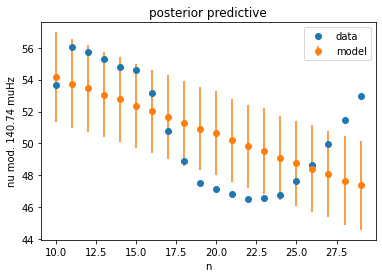

In [16]:
mean = post_pred['nu'].mean(axis=0)
sd = post_pred['nu'].std(axis=0)

fig, ax = plt.subplots()
ax.plot(n, nu%delta_nu, marker='o', linestyle='none', label='data')
ax.errorbar(n, mean%delta_nu, yerr=sd, marker='o', linestyle='none', label='model')
ax.set_xlabel('n')
ax.set_ylabel(f'nu mod. {delta_nu:.2f} muHz')
ax.set_title('posterior predictive')
ax.legend();

What if we use a GP to model the residuals

In [17]:
var = 10.0
length = 5.0

num_draws = 50
num_pred = 250
n_pred = np.linspace(n.min(), n.max(), num_pred)

rng, key = random.split(rng, 2)

kernel = SquaredExponential(var, length)
gp = GP(kernel)
dnu = gp.sample('dnu', n, sample_shape=(num_draws,), rng_key=key)

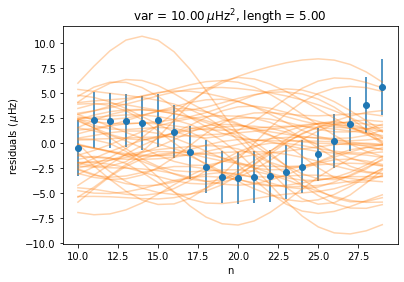

In [18]:
fig, ax = plt.subplots()

plt.errorbar(n, nu - mean, yerr=sd, color='C0', marker='o', linestyle='none')

nn = np.broadcast_to(n, dnu.shape)
ax.plot(nn.T, dnu.T, color='C1', alpha=0.33)

ax.set_xlabel('n')
ax.set_ylabel(r'residuals ($\,\mu\mathrm{Hz}$)')

ax.set_title(f'var = {var:.2f}' + r'$\,\mu\mathrm{Hz}^2$, ' + f'length = {length:.2f}');

## GP model

We know that the acoustic radial modes go as,

$$\nu_{n,l=0} \approx \Delta\nu\,(n + \epsilon)$$

where $\Delta\nu$ is the asymptotic large frequency separation and $\epsilon$ is some offset. The higher order terms are ill-defined. However, we can say that,

$$\nu = \Delta\nu\,(n + \epsilon) + g(n)$$

where we have dropped the $l=0$ and $n$ as it is hereafter implied. The function $g$ may be approximated using a Gaussian process,

$$g(\boldsymbol{n}) \approx \mathcal{GP}\left\{\boldsymbol{0}, k(\boldsymbol{n}, \boldsymbol{n}')\right\}$$

for a given vector of radial order, $\boldsymbol{n}$.

$$\boldsymbol{\nu} \approx \Delta\nu\,(\boldsymbol{n} + \epsilon) + \mathcal{GP}\left\{\boldsymbol{0}, k(\boldsymbol{n}, \boldsymbol{n}')\right\}$$

We can absorb the linear component into the GP,

$$\begin{align}
    \boldsymbol{\nu} &= f(\boldsymbol{n})\\
    f(\boldsymbol{n}) &\approx \mathcal{GP}\left\{m(\boldsymbol{n}), k(\boldsymbol{n}, \boldsymbol{n}')\right\}
\end{align}$$

where,

$$m(\boldsymbol{n}) = \Delta\nu\,(\boldsymbol{n} + \epsilon)$$

Let's convert this to a likelihood. If we observe $\boldsymbol{\nu}$ at radial order $\boldsymbol{n}_\mathcal{O}$ with noise $\zeta$, then $\boldsymbol{\nu}_\mathcal{O} = f(\boldsymbol{n}_\mathcal{O}) + \zeta$. Probabilistically, assuming the noise is independent and Gaussian with variance $\sigma^2$,

$$\boldsymbol{\nu}_\mathcal{O}\,|\,\boldsymbol{\theta} \sim \mathcal{N}\left\{\boldsymbol{m}_\mathcal{O}, K_\mathcal{OO} + \sigma^2\mathcal{I}\right\}$$

where $\boldsymbol{\theta}$ are the model parameters, $\boldsymbol{m}_i = m(\boldsymbol{n}_i)$ is the evaluated mean function, $K_{ij} = k(\boldsymbol{n}_i, \boldsymbol{n}_j)$ is the evaluated kernel, and $\mathcal{I}$ is the identity matrix. 

We can make a prediction for the true frequency $\boldsymbol{\nu}$ at positions $\boldsymbol{n}_\mathcal{P}$, $\boldsymbol{\nu}_\mathcal{P} = f(\boldsymbol{n}_\mathcal{P})$, using the joint distribution,

$$\boldsymbol{\nu}_\mathcal{O} , \boldsymbol{\nu}_\mathcal{P}  \,|\,\boldsymbol{\theta} \sim \mathcal{N}\left( \begin{bmatrix} \boldsymbol{m}_\mathcal{O} \\ \boldsymbol{m}_\mathcal{P} \end{bmatrix},  \begin{bmatrix} K_\mathcal{OO}+\sigma^2\mathcal{I} & K_\mathcal{OP} \\ K_\mathcal{OP}^T & K_\mathcal{PP} \end{bmatrix} \right)$$

The conditional probability of $\boldsymbol{\nu}_\mathcal{P}$ given $\boldsymbol{\nu}_\mathcal{O}$ is,

$$p(\boldsymbol{\nu}_\mathcal{P}\,|\,\boldsymbol{\nu}_\mathcal{O}, \boldsymbol{\theta}) = p(\boldsymbol{\nu}_\mathcal{O}\,|\,\boldsymbol{\theta})^{-1} p(\boldsymbol{\nu}_\mathcal{O}, \boldsymbol{\nu}_\mathcal{P}\,|\,\boldsymbol{\theta})$$

Therefore, using the identity for multiplying Gaussians (see eqn. A.7 in Rasmussen & Williams 2006), we get the conditional distribution,

$$\boldsymbol{\nu}_\mathcal{P}\,|\,\boldsymbol{\nu}_\mathcal{O}, \boldsymbol{\theta} \sim \mathcal{N}
\left\{ 
    \boldsymbol{m}_\mathcal{P} + K_\mathcal{OP}\cdot(K_\mathcal{OO} + \sigma^2\mathcal{I})^{-1}\cdot(\boldsymbol{\nu}_\mathcal{O} - \boldsymbol{m}_\mathcal{O}),\,
    K_\mathcal{PP} - K_\mathcal{OP}\cdot(K_\mathcal{OO} + \sigma^2\mathcal{I})^{-1}\cdot K_\mathcal{OP}^T
\right\}$$

In [115]:
from numpyro.primitives import _PYRO_STACK, apply_stack

In [120]:
def gp_model(n, n_pred=None, nu=None, nu_err=None):
    delta_nu = numpyro.sample('delta_nu', dist.Normal(141.0, 1.0))
    epsilon = numpyro.sample('epsilon', dist.Normal(1.4, 0.2))
    noise = numpyro.sample('noise', dist.HalfNormal(0.1), obs=nu_err)
    
    def mean(n):
        return delta_nu * (n + epsilon)
    
    var = 10.0
    length = 5.0
    kernel = SquaredExponential(var, length)
    gp = GP(kernel, mean=mean)
    
    nu = gp.sample('nu', n, noise=noise, obs=nu)
    loc = numpyro.deterministic('mean', mean(n))
    numpyro.deterministic('dnu', nu - loc)
    
    if n_pred is not None:
        nu_pred = gp.predict('nu_pred', n_pred)
        loc_pred = numpyro.deterministic('mean_pred', mean(n_pred))
        dnu_pred = numpyro.deterministic('dnu_pred', nu_pred - loc_pred)

In [121]:
rng, key = random.split(rng)

prior_predictive = Predictive(gp_model, num_samples=1000)
prior_pred = prior_predictive(key, n, n_pred=n_pred)

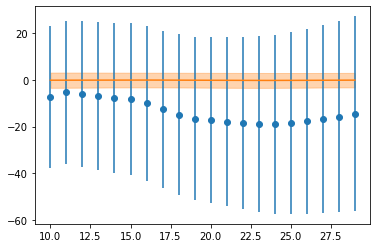

In [21]:
fig, ax = plt.subplots()

# y = nu - mean
dnu = nu - prior_pred['mean'].mean(axis=0)
dnu_err = prior_pred['mean'].std(axis=0)
ax.errorbar(n, dnu, yerr=dnu_err, marker='o', linestyle='none')

dnu_pred = prior_pred['dnu_pred'].mean(axis=0)
dnu_pred_err = prior_pred['dnu_pred'].std(axis=0)
ax.plot(n_pred, dnu_pred)
ax.fill_between(n_pred, dnu_pred-dnu_pred_err, dnu_pred+dnu_pred_err, color='C1', alpha=0.33)

In [22]:
init_strategy = init_to_median(num_samples=100)

sampler = NUTS(gp_model, target_accept_prob=0.9, init_strategy=init_strategy)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [23]:
rng, key = random.split(rng)
mcmc.run(key, n, nu=nu)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [24]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  delta_nu    140.93      0.21    140.93    140.58    141.28   2157.47      1.00
   epsilon      1.34      0.04      1.34      1.28      1.39   2147.27      1.00
     noise      0.34      0.04      0.34      0.28      0.41   2349.01      1.00

Number of divergences: 0


In [25]:
samples = mcmc.get_samples(group_by_chain=True)

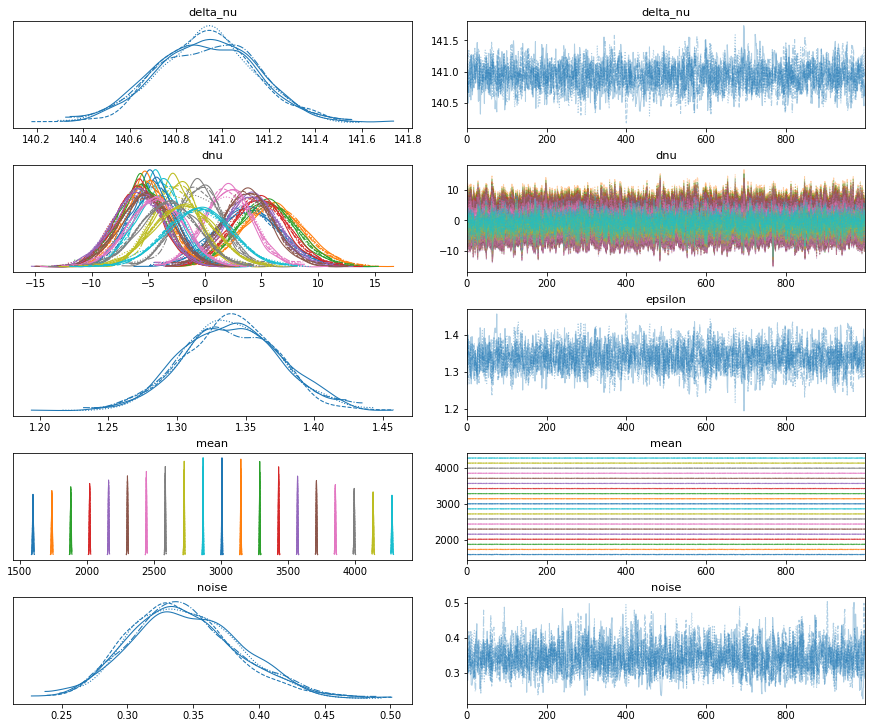

In [26]:
az.plot_trace(samples);

In [27]:
samples = mcmc.get_samples(group_by_chain=False)

In [28]:
rng, key = random.split(rng)

post_predictive = Predictive(gp_model, samples)
post_pred = post_predictive(key, n, n_pred=n_pred, nu=nu)

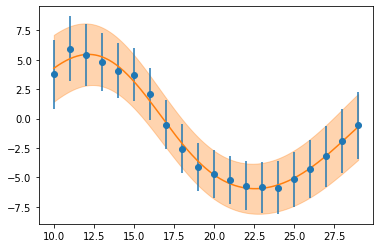

In [29]:
fig, ax = plt.subplots()

dnu = post_pred['dnu'].mean(axis=0)
dnu_err = post_pred['dnu'].std(axis=0)
ax.errorbar(n, dnu, yerr=dnu_err, marker='o', linestyle='none')

dnu_pred = post_pred['dnu_pred'].mean(axis=0)
dnu_pred_err = post_pred['dnu_pred'].std(axis=0)
ax.plot(n_pred, dnu_pred)
ax.fill_between(n_pred, dnu_pred-dnu_pred_err, dnu_pred+dnu_pred_err, color='C1', alpha=0.33)

In [30]:
rng, key = random.split(rng)

post_pred = post_predictive(key, n, n_pred=n, nu=nu)

Text(0, 0.5, 'residuals')

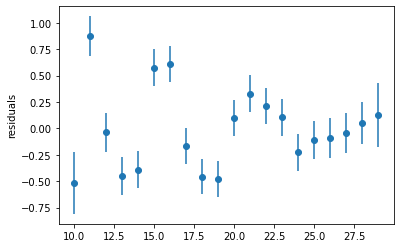

In [31]:
res = post_pred['dnu'] - post_pred['dnu_pred']

fig, ax = plt.subplots()

ax.errorbar(n, res.mean(axis=0), yerr=res.std(axis=0), marker='o', linestyle='none')
ax.set_ylabel('residuals')

This is exciting! We can see a decaying oscillation in the residuals!!! We think this is an acoustic glitch.

## Glitch with GP

### Helium glitch

In [76]:
def asy(n, delta_nu, epsilon):
    return delta_nu * (n + epsilon)

def glitch(nu, tau, phi):
    return jnp.sin(4*jnp.pi*tau*nu + phi)

def he_amplitude(nu, a, b):
    return a * nu * jnp.exp(- b * nu**2)

def he_glitch(nu, a, b, tau, phi):
    return he_amplitude(nu, a, b) * glitch(nu, tau, phi)

def glitch_model(n, n_pred=None, nu=None, nu_err=None):
    log_numax = jnp.log10(nu_max_sca)
    
    delta_nu = numpyro.sample('delta_nu', dist.Normal(141.0, 1.0))
    epsilon = numpyro.sample('epsilon', dist.Normal(1.4, 0.2))
    
    _a_he = numpyro.sample("log_a_he", dist.Normal(-1.10 - 0.35*log_numax, 0.5))
    _b_he = numpyro.sample("log_b_he", dist.Normal(0.719 - 2.14*log_numax, 0.5))
    _tau_he = numpyro.sample("log_tau_he", dist.Normal(0.44 - 1.03*log_numax, 0.1))
    
    a_he = numpyro.deterministic("a_he", 10**_a_he)
    b_he = numpyro.deterministic("b_he", 10**_b_he)
    tau_he = numpyro.deterministic('tau_he', 10**_tau_he)

    phi_he = numpyro.sample('phi_he', dist.VonMises(0.0, 0.1))
    
    noise = numpyro.sample('noise', dist.HalfNormal(0.1), obs=nu_err)
    
    def mean(n):
        nu = asy(n, delta_nu, epsilon)
        nu += he_glitch(nu, a_he, b_he, tau_he, phi_he)
        return nu
    
    var = 10.0
    length = 5.0
    kernel = SquaredExponential(var, length)
    gp = GP(kernel, mean=mean)
    
    nu = gp.sample('nu', n, noise=noise, obs=nu)
    loc = numpyro.deterministic('mean', mean(n))
    numpyro.deterministic('res', nu - loc)
    
    nu_asy = numpyro.deterministic('nu_asy', asy(n, delta_nu, epsilon))
    numpyro.deterministic('dnu_he', he_glitch(nu_asy, a_he, b_he, tau_he, phi_he))
    
    if n_pred is not None:
        nu_pred = gp.predict('nu_pred', n_pred)
        loc_pred = numpyro.deterministic('mean_pred', mean(n_pred))
        numpyro.deterministic('res_pred', nu_pred - loc_pred)
        
        nu_asy_pred = numpyro.deterministic('nu_asy_pred', asy(n_pred, delta_nu, epsilon))
        numpyro.deterministic('dnu_he_pred', he_glitch(nu_asy_pred, a_he, b_he, tau_he, phi_he))

In [61]:
rng, key = random.split(rng)

prior_predictive = Predictive(glitch_model, num_samples=1000)
prior_pred = prior_predictive(key, n, n_pred=n_pred)

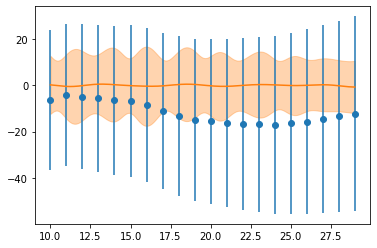

In [62]:
fig, ax = plt.subplots()

dnu_he = nu - (prior_pred['nu_asy'] + prior_pred['res'])
dnu_he_mean = dnu_he.mean(axis=0)
dnu_he_sd = dnu_he.std(axis=0)
# dnu_err = prior_pred['mean'].std(axis=0)
ax.errorbar(n, dnu_he_mean, yerr=dnu_he_sd, marker='o', linestyle='none')

dnu_he_pred = prior_pred['dnu_he_pred'].mean(axis=0)
dnu_he_pred_err = prior_pred['dnu_he_pred'].std(axis=0)
ax.plot(n_pred, dnu_he_pred)
ax.fill_between(n_pred, dnu_he_pred-dnu_he_pred_err, dnu_he_pred+dnu_he_pred_err, color='C1', alpha=0.33)

In [63]:
reparam_model = handlers.reparam(
    glitch_model,
    config={
        'phi_he': CircularReparam(),
    },
)

In [64]:
init_strategy = init_to_median(num_samples=100)

sampler = NUTS(reparam_model, target_accept_prob=0.9, init_strategy=init_strategy)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [65]:
rng, key = random.split(rng)
mcmc.run(key, n, nu=nu)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [66]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
          delta_nu    141.07      0.21    141.07    140.73    141.41   1956.06      1.00
           epsilon      1.31      0.03      1.31      1.26      1.37   1951.33      1.00
          log_a_he     -2.68      0.14     -2.68     -2.93     -2.47   2316.87      1.00
          log_b_he     -6.45      0.08     -6.45     -6.59     -6.33   2395.11      1.00
        log_tau_he     -3.16      0.02     -3.16     -3.19     -3.14   1675.51      1.00
             noise      0.14      0.03      0.13      0.09      0.19   2002.59      1.00
  phi_he_unwrapped      0.50      2.60     -0.49     -1.83      6.01      2.67      3.92

Number of divergences: 0


In [67]:
samples = mcmc.get_samples(group_by_chain=True)

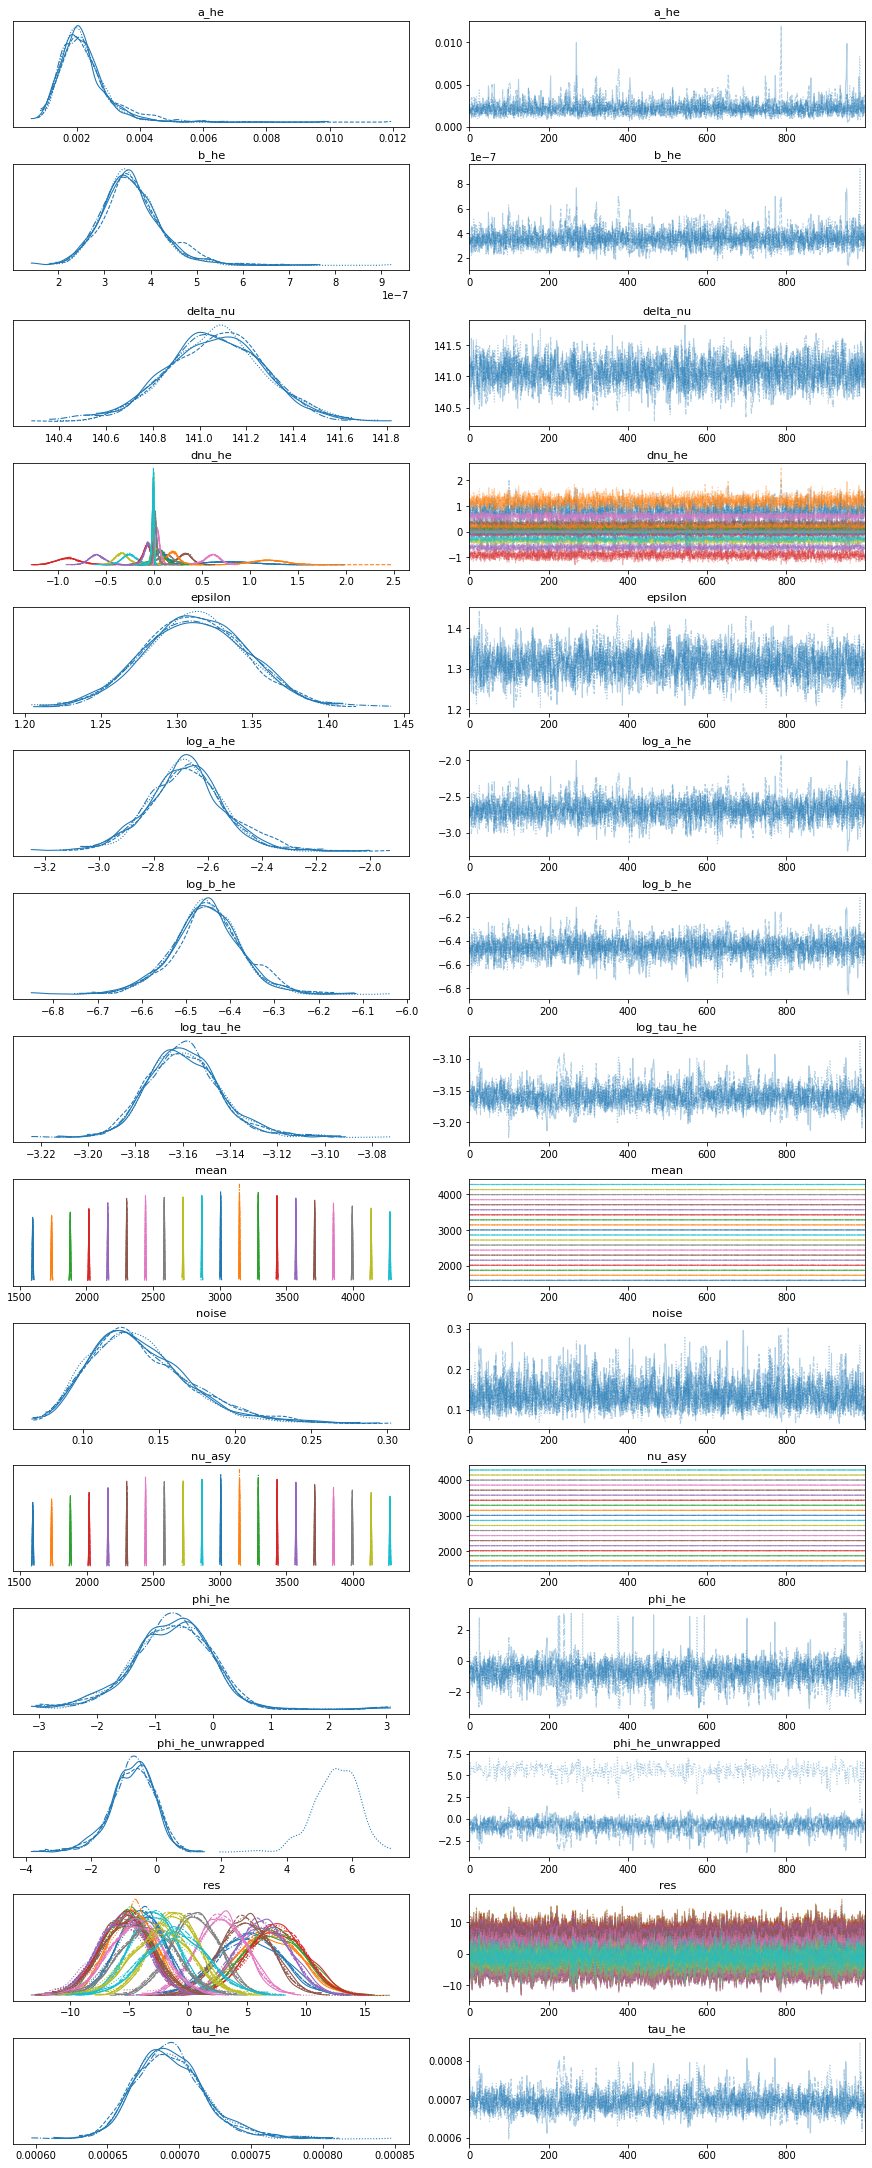

In [68]:
az.plot_trace(samples);

In [70]:
samples = mcmc.get_samples(group_by_chain=False)

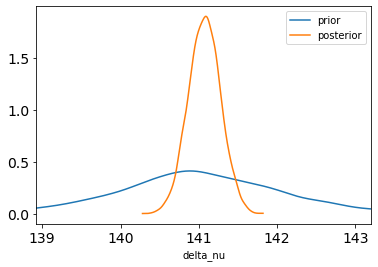

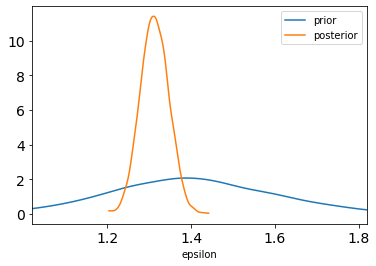

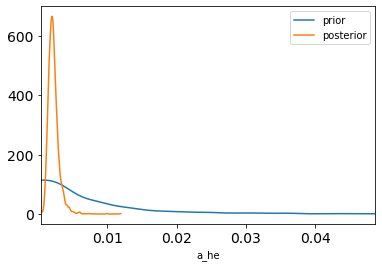

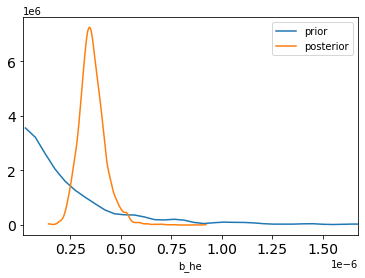

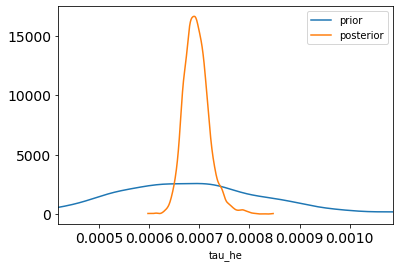

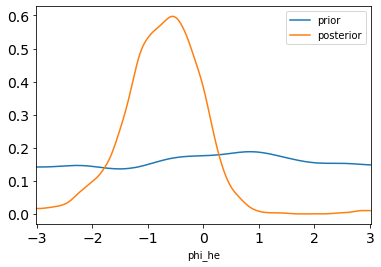

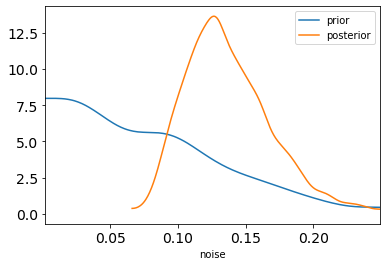

In [73]:
var_names = ['delta_nu', 'epsilon', 'a_he', 'b_he', 'tau_he', 'phi_he', 'noise']

for k in var_names:
    prior_low, prior_up = np.quantile(prior_pred[k].ravel(), [.02, .98])
    post_low, post_up = np.quantile(samples[k].ravel(), [.02, .98])
    lower = np.min([prior_low, post_low])
    upper = np.max([prior_up, post_up])
    
    fig, ax = plt.subplots()
    az.plot_kde(prior_pred[k], ax=ax, label='prior')
    az.plot_kde(samples[k], ax=ax, plot_kwargs={'color': 'C1'}, label='posterior')
    ax.set_xlabel(k)
    ax.legend()
    ax.set_xlim(lower, upper)

In [42]:
rng, key = random.split(rng)

post_predictive = Predictive(glitch_model, samples)
post_pred = post_predictive(key, n, n_pred=n_pred, nu=nu)

In [43]:
n_max = nu_max_sca / samples['delta_nu'] - samples['epsilon']
n_max_mean = n_max.mean(axis=0)
n_max_err = n_max.std(axis=0)

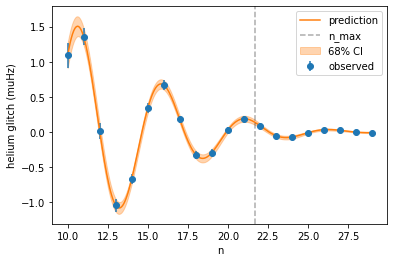

In [44]:
fig, ax = plt.subplots()

dnu_he = post_pred['dnu_he']
dnu_he_mean = dnu_he.mean(axis=0)
dnu_he_sd = dnu_he.std(axis=0)
# dnu_err = prior_pred['mean'].std(axis=0)
ax.errorbar(n, dnu_he_mean, yerr=dnu_he_sd, marker='o', linestyle='none', label='observed')

dnu_he_pred = post_pred['dnu_he_pred'].mean(axis=0)
dnu_he_pred_err = post_pred['dnu_he_pred'].std(axis=0)
ax.plot(n_pred, dnu_he_pred, label='prediction')
ax.fill_between(n_pred, dnu_he_pred-dnu_he_pred_err, dnu_he_pred+dnu_he_pred_err, color='C1', alpha=0.33, label='68% CI')

ax.axvline(n_max_mean, linestyle='--', color='k', alpha=0.33, label='n_max')

ax.legend()
ax.set_xlabel('n')
ax.set_ylabel('helium glitch (muHz)');

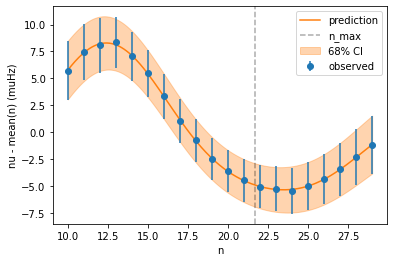

In [45]:
fig, ax = plt.subplots()

res = post_pred['res'].mean(axis=0)
res_err = post_pred['res'].std(axis=0)
ax.errorbar(n, res, yerr=res_err, marker='o', linestyle='none', label='observed')

res_pred = post_pred['res_pred'].mean(axis=0)
res_pred_err = post_pred['res_pred'].std(axis=0)
ax.plot(n_pred, res_pred, label='prediction')
ax.fill_between(n_pred, res_pred-res_pred_err, res_pred+res_pred_err, color='C1', alpha=0.33, label='68% CI')

ax.axvline(n_max_mean, linestyle='--', color='k', alpha=0.33, label='n_max')

ax.set_xlabel('n')
ax.set_ylabel('nu - mean(n) (muHz)')
ax.legend();

In [46]:
rng, key = random.split(rng)

post_pred = post_predictive(key, n, n_pred=n, nu=nu)

Text(0, 0.5, 'residuals')

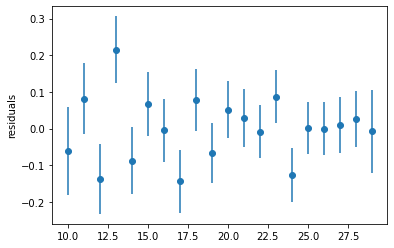

In [47]:
res = post_pred['res'] - post_pred['res_pred']

fig, ax = plt.subplots()

ax.errorbar(n, res.mean(axis=0), yerr=res.std(axis=0), marker='o', linestyle='none')
ax.set_ylabel('residuals')

### Base conv. zone glitch

In [77]:
def cz_amplitude(nu, a):
    return a / nu**2

def cz_glitch(nu, a, tau, phi):
    return cz_amplitude(nu, a) * glitch(nu, tau, phi)

def glitch_model_2(n, n_pred=None, nu=None, nu_err=None):
    log_numax = jnp.log10(nu_max_sca)
    
    delta_nu = numpyro.sample('delta_nu', dist.Normal(141.0, 1.0))
    epsilon = numpyro.sample('epsilon', dist.Normal(1.4, 0.2))
    
    _a_he = numpyro.sample("log_a_he", dist.Normal(-1.10 - 0.35*log_numax, 0.5))
    _b_he = numpyro.sample("log_b_he", dist.Normal(0.719 - 2.14*log_numax, 0.5))
    _tau_he = numpyro.sample("log_tau_he", dist.Normal(0.44 - 1.03*log_numax, 0.1))
    
    a_he = numpyro.deterministic("a_he", 10**_a_he)
    b_he = numpyro.deterministic("b_he", 10**_b_he)
    tau_he = numpyro.deterministic('tau_he', 10**_tau_he)

    phi_he = numpyro.sample('phi_he', dist.VonMises(0.0, 0.1))
    
    _a_cz = numpyro.sample("log_a_cz", dist.Normal(2*log_numax - 1.0, 0.5))
    _tau_cz = numpyro.sample("log_tau_cz", dist.Normal(0.77 - 0.99*log_numax, 0.1))
    
    a_cz = numpyro.deterministic("a_cz", 10**_a_cz)
    tau_cz = numpyro.deterministic("tau_cz", 10**_tau_cz)
    
    phi_cz = numpyro.sample('phi_cz', dist.VonMises(0.0, 0.1))
    
    noise = numpyro.sample('noise', dist.HalfNormal(0.1), obs=nu_err)
    
    def mean(n):
        nu = asy(n, delta_nu, epsilon)
        nu += he_glitch(nu, a_he, b_he, tau_he, phi_he)
        nu += cz_glitch(nu, a_cz, tau_cz, phi_cz)
        return nu
    
    var = 10.0
    length = 5.0
    kernel = SquaredExponential(var, length)
    gp = GP(kernel, mean=mean)
    
    nu = gp.sample('nu', n, noise=noise, obs=nu)
    loc = numpyro.deterministic('mean', mean(n))
    numpyro.deterministic('res', nu - loc)
    
    nu_asy = numpyro.deterministic('nu_asy', asy(n, delta_nu, epsilon))
    numpyro.deterministic('dnu_he', he_glitch(nu_asy, a_he, b_he, tau_he, phi_he))
    numpyro.deterministic('dnu_cz', cz_glitch(nu_asy, a_cz, tau_cz, phi_cz))
    
    if n_pred is not None:
        nu_pred = gp.predict('nu_pred', n_pred)
        loc_pred = numpyro.deterministic('mean_pred', mean(n_pred))
        numpyro.deterministic('res_pred', nu_pred - loc_pred)
        
        nu_asy_pred = numpyro.deterministic('nu_asy_pred', asy(n_pred, delta_nu, epsilon))
        numpyro.deterministic('dnu_he_pred', he_glitch(nu_asy_pred, a_he, b_he, tau_he, phi_he))
        numpyro.deterministic('dnu_cz_pred', cz_glitch(nu_asy_pred, a_cz, tau_cz, phi_cz))

In [78]:
rng, key = random.split(rng)

prior_predictive = Predictive(glitch_model_2, num_samples=1000)
prior_pred = prior_predictive(key, n, n_pred=n_pred)

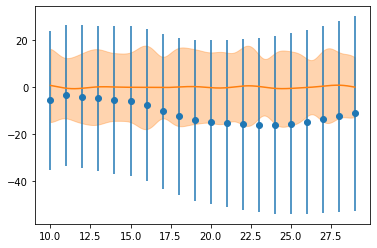

In [79]:
fig, ax = plt.subplots()

dnu_he = nu - (prior_pred['nu_asy'] + prior_pred['res'])
dnu_he_mean = dnu_he.mean(axis=0)
dnu_he_sd = dnu_he.std(axis=0)
# dnu_err = prior_pred['mean'].std(axis=0)
ax.errorbar(n, dnu_he_mean, yerr=dnu_he_sd, marker='o', linestyle='none')

dnu_he_pred = prior_pred['dnu_he_pred'].mean(axis=0)
dnu_he_pred_err = prior_pred['dnu_he_pred'].std(axis=0)
ax.plot(n_pred, dnu_he_pred)
ax.fill_between(n_pred, dnu_he_pred-dnu_he_pred_err, dnu_he_pred+dnu_he_pred_err, color='C1', alpha=0.33)

In [83]:
reparam_model = handlers.reparam(
    glitch_model_2,
    config={
        'phi_he': CircularReparam(),
        'phi_cz': CircularReparam(),
    },
)

In [90]:
init_strategy = init_to_median(num_samples=100)

sampler = NUTS(reparam_model, target_accept_prob=0.95, init_strategy=init_strategy)
mcmc = MCMC(sampler, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [91]:
rng, key = random.split(rng)
mcmc.run(key, n, nu=nu)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [92]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
          delta_nu    141.09      0.21    141.08    140.76    141.43   1183.79      1.01
           epsilon      1.31      0.04      1.31      1.25      1.36    884.81      1.01
          log_a_cz      5.85      0.19      5.84      5.65      5.97     28.60      1.15
          log_a_he     -2.64      0.11     -2.63     -2.80     -2.49    114.44      1.04
          log_b_he     -6.44      0.05     -6.44     -6.52     -6.37    139.75      1.04
        log_tau_cz     -2.74      0.09     -2.69     -2.85     -2.67     17.48      1.67
        log_tau_he     -3.17      0.01     -3.17     -3.18     -3.15    749.03      1.01
             noise      0.06      0.03      0.05      0.02      0.10    103.47      1.05
  phi_cz_unwrapped      3.22     44.12      0.86    -84.00     68.67      3.25      3.00
  phi_he_unwrapped     -0.35      0.51     -0.32     -1.02      0.38    835.91      1.01

Number of divergenc

In [104]:
samples = mcmc.get_samples(group_by_chain=True)

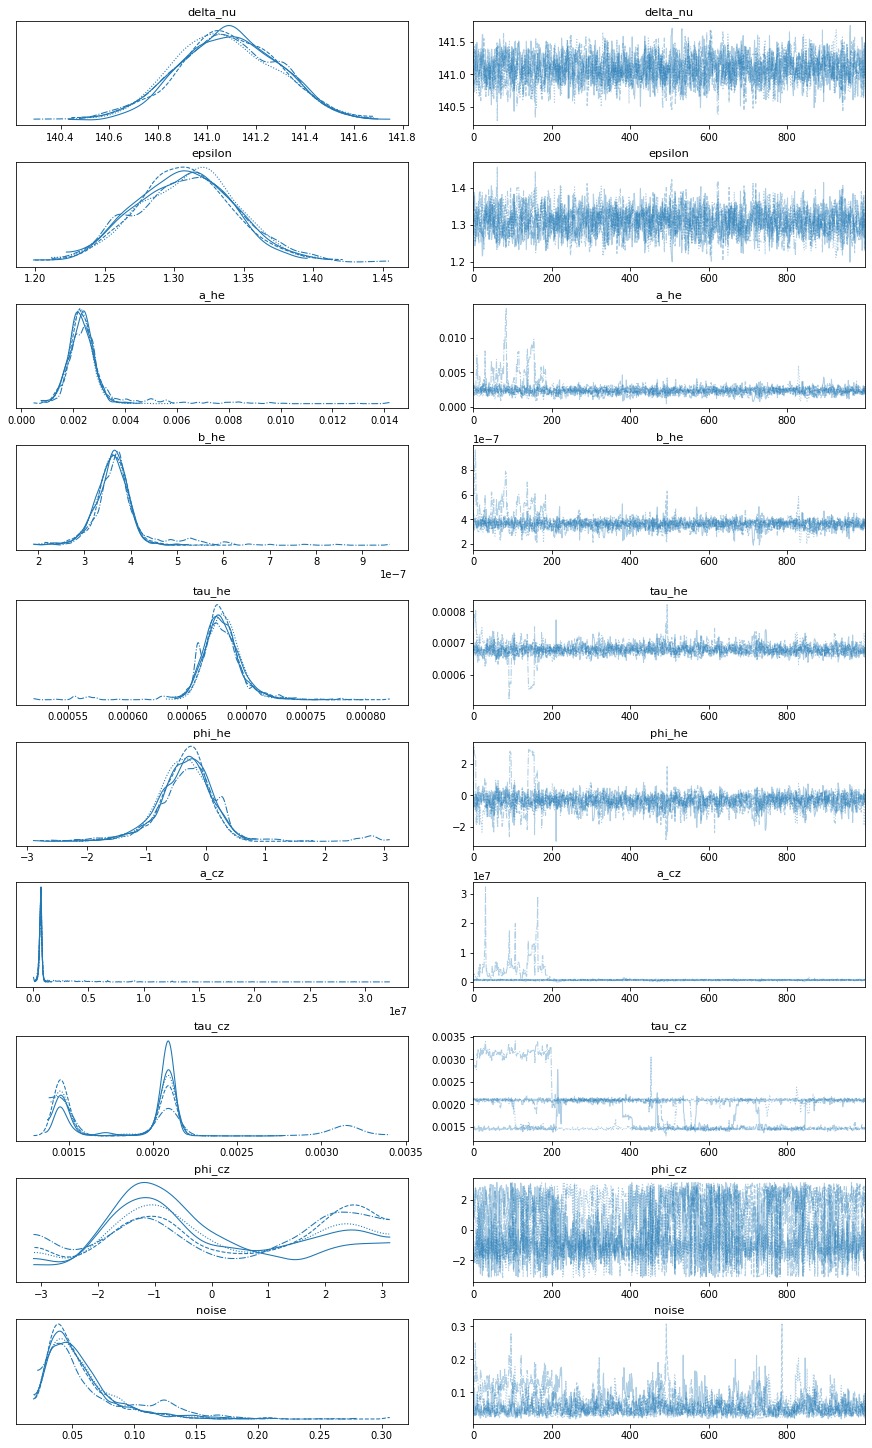

In [106]:
var_names = ['delta_nu', 'epsilon', 'a_he', 'b_he', 'tau_he', 'phi_he', 'a_cz', 'tau_cz', 'phi_cz', 'noise']

az.plot_trace(samples, var_names=var_names);

In [107]:
samples = mcmc.get_samples(group_by_chain=False)

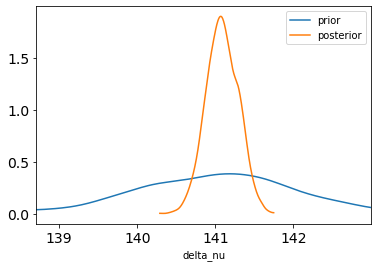

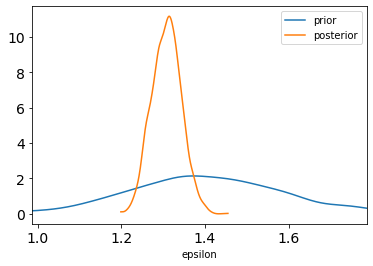

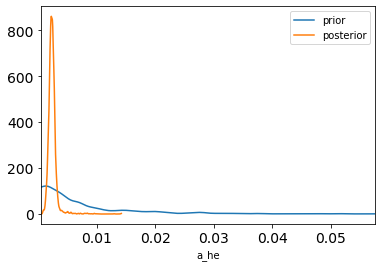

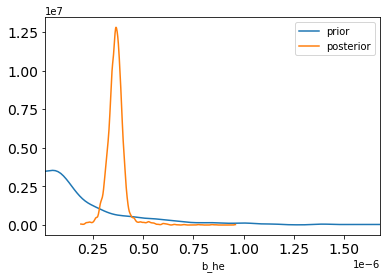

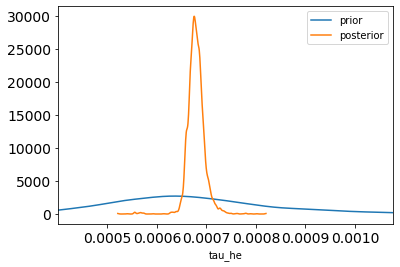

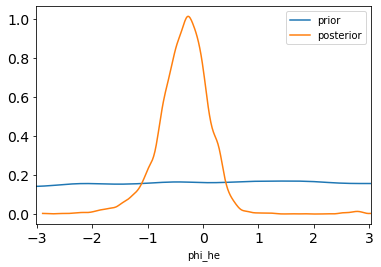

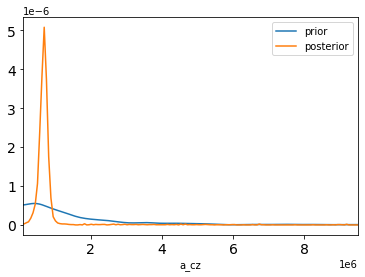

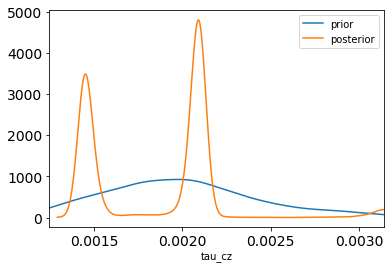

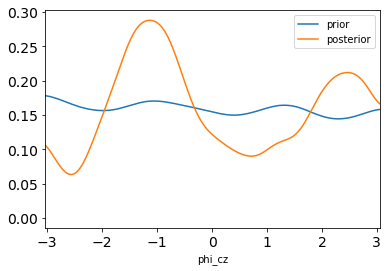

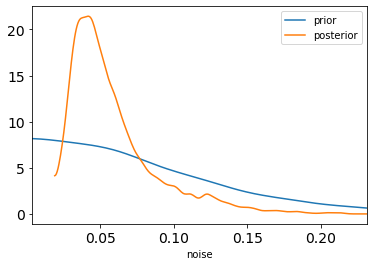

In [108]:
for k in var_names:
    prior_low, prior_up = np.quantile(prior_pred[k].ravel(), [.02, .98])
    post_low, post_up = np.quantile(samples[k].ravel(), [.02, .98])
    lower = np.min([prior_low, post_low])
    upper = np.max([prior_up, post_up])
    
    fig, ax = plt.subplots()
    az.plot_kde(prior_pred[k], ax=ax, label='prior')
    az.plot_kde(samples[k], ax=ax, plot_kwargs={'color': 'C1'}, label='posterior')
    ax.set_xlabel(k)
    ax.legend()
    ax.set_xlim(lower, upper)

In [98]:
rng, key = random.split(rng)

post_predictive = Predictive(glitch_model_2, samples)
post_pred = post_predictive(key, n, n_pred=n_pred, nu=nu)

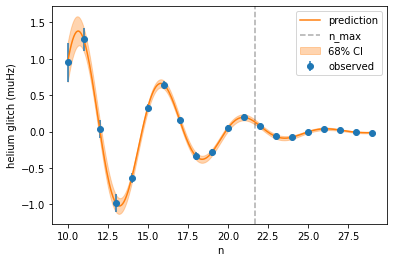

In [99]:
fig, ax = plt.subplots()

dnu_he = post_pred['dnu_he']
dnu_he_mean = dnu_he.mean(axis=0)
dnu_he_sd = dnu_he.std(axis=0)
# dnu_err = prior_pred['mean'].std(axis=0)
ax.errorbar(n, dnu_he_mean, yerr=dnu_he_sd, marker='o', linestyle='none', label='observed')

dnu_he_pred = post_pred['dnu_he_pred'].mean(axis=0)
dnu_he_pred_err = post_pred['dnu_he_pred'].std(axis=0)
ax.plot(n_pred, dnu_he_pred, label='prediction')
ax.fill_between(n_pred, dnu_he_pred-dnu_he_pred_err, dnu_he_pred+dnu_he_pred_err, color='C1', alpha=0.33, label='68% CI')

ax.axvline(n_max_mean, linestyle='--', color='k', alpha=0.33, label='n_max')

ax.legend()
ax.set_xlabel('n')
ax.set_ylabel('helium glitch (muHz)');

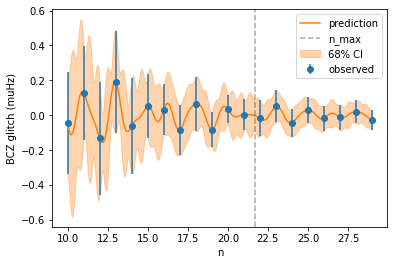

In [101]:
fig, ax = plt.subplots()

dnu_cz = post_pred['dnu_cz']
dnu_cz_mean = dnu_cz.mean(axis=0)
dnu_cz_sd = dnu_cz.std(axis=0)
# dnu_err = prior_pred['mean'].std(axis=0)
ax.errorbar(n, dnu_cz_mean, yerr=dnu_cz_sd, marker='o', linestyle='none', label='observed')

dnu_cz_pred = post_pred['dnu_cz_pred'].mean(axis=0)
dnu_cz_pred_err = post_pred['dnu_cz_pred'].std(axis=0)
ax.plot(n_pred, dnu_cz_pred, label='prediction')
ax.fill_between(n_pred, dnu_cz_pred-dnu_cz_pred_err, dnu_cz_pred+dnu_cz_pred_err, color='C1', alpha=0.33, label='68% CI')

ax.axvline(n_max_mean, linestyle='--', color='k', alpha=0.33, label='n_max')

ax.legend()
ax.set_xlabel('n')
ax.set_ylabel('BCZ glitch (muHz)');

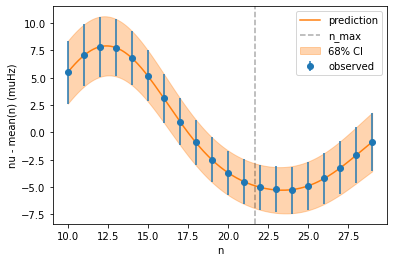

In [102]:
fig, ax = plt.subplots()

res = post_pred['res'].mean(axis=0)
res_err = post_pred['res'].std(axis=0)
ax.errorbar(n, res, yerr=res_err, marker='o', linestyle='none', label='observed')

res_pred = post_pred['res_pred'].mean(axis=0)
res_pred_err = post_pred['res_pred'].std(axis=0)
ax.plot(n_pred, res_pred, label='prediction')
ax.fill_between(n_pred, res_pred-res_pred_err, res_pred+res_pred_err, color='C1', alpha=0.33, label='68% CI')

ax.axvline(n_max_mean, linestyle='--', color='k', alpha=0.33, label='n_max')

ax.set_xlabel('n')
ax.set_ylabel('nu - mean(n) (muHz)')
ax.legend();